In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import metrics
from langdetect import detect

## Phase 4 - Modeling

### 4.0 -  Load the data

I've got two main dataframes I'll try adding, 
    1. the straightforward title which will need to be vectorized and tested
    2. my 'kitchen sink' dataframe that has a number of engineered features such as word count and sentiment analysis scores.

In [2]:
base_df = pd.read_csv('./data/clean_reddit_data.csv')
ks_df = pd.read_csv('./data/kitchen-sink-approach.csv')

In [3]:
# convert the base_df subreddit column to 1's and 0's
base_df['subreddit'] = base_df['subreddit'].map({'bestoflegaladvice': 1, 'legaladvice': 0})

### 4.1 Train/Test/Split

In [4]:
X = base_df['title']
y = base_df['subreddit']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 9) # for the Mighty Nein!

### 4.2 Logistic Regression

In this segment I'm going to test a Logistic Regression classifier with both the CountVectorizer method and the TF-IDF Vectorizer.
For each of the two models I'll use a pipeline and gridsearchCV to tune for the best model in terms of accuracy and compare the results of the two grid searches.

#### Logistic Regression with Count Vectorizer

In [6]:
cvec_logreg_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logregcv', LogisticRegressionCV())
])

In [7]:
cvec_logreg_pipe_params = {
    'cvec__stop_words' : [None,'english'],
    'cvec__max_features' : [2000, 3500, 5000],# Maximum number of features fit: 2000, 3000, 4000, 5000
    'cvec__min_df' : [ 2, 3],                       # Minimum number of documents needed to include token: 2, 3
    'cvec__max_df' : [.8, .9],                     # Maximum number of documents needed to include token: 80%, 90%
    'cvec__ngram_range' : [(1, 1), (1, 2)],          # Check (individual tokens) and also check (individual tokens and 2-grams).
    'logregcv__penalty' : [None, 'l1', 'l2'],
    'logregcv__solver' : ['liblinear']

}

cvec_logreg_gs = GridSearchCV(cvec_logreg_pipe, cvec_logreg_pipe_params, cv = 5, n_jobs = -2, verbose = 1)

In [8]:
cvec_logreg_gs.fit(X_train, y_train);

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-2)]: Done 720 out of 720 | elapsed:  3.0min finished


In [11]:
cvec_logreg_gs.score(X_train, y_train), cvec_logreg_gs.score(X_test, y_test)

(0.9426666666666667, 0.8932)

Okay, first hack at this with Logistic Regression CV and we've got a model that fits with 93.5% accuracy on training data and 83.8 % accuracy on test data.  This is overfit by more than 10%.   Let's try that with TF-IDF next.

#### Logistic Regression with TF-IDF

In [12]:
tvec_logreg_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logregcv', LogisticRegressionCV())
])

tvec_logreg_pipe_params = {
    'tvec__stop_words' : [None,'english'], #include stopwords or not?
    'tvec__max_features' : [2000, 3500, 5000],# Maximum number of features fit: 2000, 3000, 4000, 5000
    'tvec__ngram_range' : [(1, 1), (1, 2)],          # Check (individual tokens) and also check (individual tokens and 2-grams).
    'logregcv__penalty' : [None, 'l1', 'l2'], #Are we not regularizing, using LASSO regularization or ridge regularization?
    'logregcv__solver' : ['liblinear']

}
tvec_logreg_gs = GridSearchCV(tvec_logreg_pipe, tvec_logreg_pipe_params, cv = 5, n_jobs = -2, verbose = 1)

In [13]:
tvec_logreg_gs.fit(X_train, y_train);

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-2)]: Done 180 out of 180 | elapsed:   33.7s finished


In [16]:
tvec_logreg_gs.score(X_train, y_train), tvec_logreg_gs.score(X_test, y_test)

(0.946, 0.892)

Okay, better.  We're seeing  94.6% accuracy on training data and 89.2% accuracy on test data.  6% variance between the two is pushing it and its still overfit, but this is better than using CountVectorizer.

### 4.3 K-Nearest Neighbors

In [17]:
cvec_knn_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

cvec_knn_pipe_params = {
    'cvec__stop_words' : [None,'english'],
    'cvec__max_features' : [2000, 3500, 5000],# Maximum number of features fit: 2000, 3000, 4000, 5000
    'cvec__min_df' : [ 2, 3],                 # Minimum number of documents needed to include token: 2, 3
    'cvec__max_df' : [.8, .9],                # Maximum number of documents needed to include token: 90%, 95%
    'cvec__ngram_range' : [(1, 1), (1, 2)],   # Check (individual tokens) and also check (individual tokens and 2-grams).
    'knn__n_neighbors' : [3, 5, 7],           # check for 3, 5, 7 neighbors  
    'knn__weights' : ['uniform', 'distance']  # knn weight types
}
cvec_knn_gs = GridSearchCV(cvec_knn_pipe, cvec_knn_pipe_params, cv = 5, verbose = 1, n_jobs = -2)

In [18]:
cvec_knn_gs.fit(X_train, y_train);
cvec_knn_gs.score(X_train, y_train), cvec_knn_gs.score(X_test, y_test)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done 1236 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done 1440 out of 1440 | elapsed:  2.3min finished


(0.9932, 0.7176)

First look at using KNN with this dataframe... not looking good.  Using count vectorizer we got a massively overfit model with 99%, 72% train/test scores.  Nicht so Gut.

In [19]:
tvec_knn_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

tvec_knn_pipe_params = {
    'tvec__stop_words' : [None,'english'],
    'tvec__max_features' : [2000, 3500, 5000],# Maximum number of features fit: 2000, 3000, 4000, 5000
    'tvec__ngram_range' : [(1, 1), (1, 2)],   # Check (individual tokens) and also check (individual tokens and 2-grams).
    'knn__n_neighbors' : [3, 5, 7],           # check for 3, 5, 7 neighbors  
    'knn__weights' : ['uniform', 'distance']  # knn weight types
}
tvec_knn_gs = GridSearchCV(tvec_knn_pipe, tvec_knn_pipe_params, cv = 5, verbose = 1, n_jobs = -2)

In [20]:
tvec_knn_gs.fit(X_train, y_train);
tvec_knn_gs.score(X_train, y_train), tvec_knn_gs.score(X_test, y_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-2)]: Done 360 out of 360 | elapsed:   34.9s finished


(0.9884, 0.5792)

Second look at using KNN with this dataframe... also not looking good.  Using TF-IDF vectorizer we got a massively overfit model with 98%, 61% train/test split.  Worse than CVec, and still a high level of variance.

### 4.4 Multinomial Naive Bayes

In [21]:
cvec_mnnb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnnb', MultinomialNB())
])

cvec_mnnb_pipe_params = {
    'cvec__stop_words' : [None,'english'],
    'cvec__max_features' : [2000, 3000, 4000, 5000],# Maximum number of features fit: 2000, 3000, 4000, 5000
    'cvec__min_df' : [ 2, 3],                 # Minimum number of documents needed to include token: 2, 3
    'cvec__max_df' : [.8, .9, .95],                # Maximum number of documents needed to include token: 80%, 90%, 95%
    'cvec__ngram_range' : [(1, 1), (1, 2)],   # Check (individual tokens) and also check (individual tokens and 2-grams).
}
cvec_mnnb_gs = GridSearchCV(cvec_mnnb_pipe, cvec_mnnb_pipe_params, cv = 5, verbose = 1, n_jobs = -2)

In [22]:
cvec_mnnb_gs.fit(X_train, y_train)
cvec_mnnb_gs.score(X_train, y_train), cvec_mnnb_gs.score(X_test, y_test)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-2)]: Done 358 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-2)]: Done 480 out of 480 | elapsed:   22.9s finished


(0.9065333333333333, 0.8792)

All right!  Now we're talking-  we've got a 91.3% accuracy rating on the training data and a 87% accuracy on the test data.  So far, this is our best model.

In [24]:
cvec_mnnb_gs.best_score_

0.8685333333333333

In [25]:
tvec_mnnb_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnnb', MultinomialNB())
])

tvec_mnnb_pipe_params = {
    'tvec__stop_words' : [None,'english'],              #Check default english stopwords and no stopwords.
    'tvec__max_features' : [2000, 3500, 4000, 5000],    # Maximum number of features fit: 2000, 3000, 4000, 5000
    'tvec__ngram_range' : [(1, 1), (1, 2)],             # Check (individual tokens) and also check (individual tokens and 2-grams).
}
tvec_mnnb_gs = GridSearchCV(tvec_mnnb_pipe, tvec_mnnb_pipe_params, cv = 5, verbose = 1, n_jobs = -2)

In [26]:
tvec_mnnb_gs.fit(X_train, y_train)
tvec_mnnb_gs.score(X_train, y_train), tvec_mnnb_gs.score(X_test, y_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-2)]: Done  80 out of  80 | elapsed:    3.9s finished


(0.9129333333333334, 0.8728)

### 4.5 Random Forest

In [27]:
cvec_rf_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

cvec_rf_pipe_params = {
    'cvec__stop_words' : [None],                             'cvec__max_features' : [2000, 5000],                     'cvec__min_df' : [ 2, 3],                                'cvec__max_df' : [.8, .9 ],                          
    'cvec__ngram_range' : [(1, 2)],                      
    'rf__n_estimators' : [100, 250, 500],                    'rf__bootstrap' :  [True],                               'rf__max_depth' : [10, 25, 50],                          'rf__min_samples_split' : [ 5, 10],                      'rf__min_samples_leaf' : [ 2, 4],                    
}
cvec_rf_gs = GridSearchCV(cvec_rf_pipe, cvec_rf_pipe_params, cv = 3, verbose = 1, n_jobs = -2)

In [28]:
cvec_rf_gs.fit(X_train, y_train)
cvec_rf_gs.score(X_train, y_train), cvec_rf_gs.score(X_test, y_test)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-2)]: Done 864 out of 864 | elapsed:  4.4min finished


(0.9098666666666667, 0.8756)

Decision trees and random forests are prone to overfitting, so its not surprising that running a random forest classifier with default parameters produces an overfit model.  

Default RF Params: Train/Test accuracy split of 99.6%, 86.8 %

Tuned RF Params:   Train/Test accuracy split 90.9%, 87.56%

In [29]:
tvec_rf_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

tvec_rf_pipe_params = {
    'tvec__max_features' : [2000, 5000],    # Maximum number of features fit: 2000, 5000
    'tvec__ngram_range' : [(1, 2)],             # Check (individual tokens) and also check (individual tokens and 2-grams).
    'rf__n_estimators' : [100, 250, 500],               # number of trees in the forest
    'rf__bootstrap' :  [True],                   # to bootstrap or not to bootstrap?
    'rf__max_depth' : [10, 50],                     # max number of levels per tree
    'rf__max_features' : ['auto', None],                 # bagging or not?
    'rf__min_samples_split' : [ 5, 10],                 # min number of points in a node before the node is split
    'rf__min_samples_leaf' : [ 2, 4],                   # min number of data points allowed in a leaf node

}
tvec_rf_gs = GridSearchCV(tvec_rf_pipe, tvec_rf_pipe_params, cv = 3, verbose = 1, n_jobs= -2)

In [30]:
tvec_rf_gs.fit(X_train, y_train)
tvec_rf_gs.score(X_train, y_train), tvec_rf_gs.score(X_test, y_test)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-2)]: Done 288 out of 288 | elapsed: 12.6min finished


(0.9213333333333333, 0.8724)

Decision trees and random forests are prone to overfitting, so its not surprising that running a random forest classifier with default parameters produces an overfit model.  Train/Test accuracy split of 99.6%, 86.8 %

Some model tuning later and it's been improved to 92.1 % / 87.08%.

## Phase 5 - Model Analysis
    

### 5.0 Baseline Score

In [67]:
y.value_counts()

1    5000
0    5000
Name: subreddit, dtype: int64

This dataset has a 50/50 split of the two subreddits, meaning the score of a model that predicts every data point to be either subreddit would be 50% accurate.  This will be the baseline we compare against.

### 5.1 - Model Scoring and Evaluation.

In [33]:
accuracy_summary = {
    'Count Vectorized Logistic Regression' : [round(cvec_logreg_gs.score(X_train, y_train), 2), round(cvec_logreg_gs.score(X_test, y_test), 2)],
    'TF-IDF Logistic Regression' : [round(tvec_logreg_gs.score(X_train, y_train), 2), round(tvec_logreg_gs.score(X_test, y_test), 2)],
    'Count Vectorized K-Nearest Neighbors' : [round(cvec_knn_gs.score(X_train, y_train), 2), round(cvec_knn_gs.score(X_test, y_test), 2)],
    "TF-IDF Vectorized K-Nearest Neighbors" : [round(tvec_knn_gs.score(X_train, y_train), 2), round(tvec_knn_gs.score(X_test, y_test), 2)],
    "Count Vectorized Multinomial Naive Bayes" : [round(cvec_mnnb_gs.score(X_train, y_train), 2), round(tvec_mnnb_gs.score(X_test, y_test), 2)],
    "TF-IDF Vectorized Multinomial Naive Bayes" : [round(tvec_mnnb_gs.score(X_train, y_train), 2), round(tvec_mnnb_gs.score(X_test, y_test), 2)],
    "Count Vectorized Random Forest" : [round(cvec_rf_gs.score(X_train, y_train), 2), round(cvec_rf_gs.score(X_test, y_test), 2)],
    "TF-IDF Vectorized Random Forest" : [round(tvec_rf_gs.score(X_train, y_train), 2), round(tvec_rf_gs.score(X_test, y_test), 2)],
    }

In [35]:
accuracy_df = pd.DataFrame.from_dict(accuracy_summary, orient='index',
                       columns=['Train', 'Test'])
accuracy_df['Variance'] = abs(accuracy_df['Train'] - accuracy_df['Test'])
accuracy_df

,Train,Test,Variance
Count Vectorized Logistic Regression,0.94,0.89,0.05
TF-IDF Logistic Regression,0.95,0.89,0.06
Count Vectorized K-Nearest Neighbors,0.99,0.72,0.27
TF-IDF Vectorized K-Nearest Neighbors,0.99,0.58,0.41
Count Vectorized Multinomial Naive Bayes,0.91,0.87,0.04
TF-IDF Vectorized Multinomial Naive Bayes,0.91,0.87,0.04
Count Vectorized Random Forest,0.91,0.88,0.03
TF-IDF Vectorized Random Forest,0.92,0.87,0.05


In [36]:
accuracy_df.to_csv('./data/accuracy_data.csv')

<Figure size 720x1440 with 0 Axes>

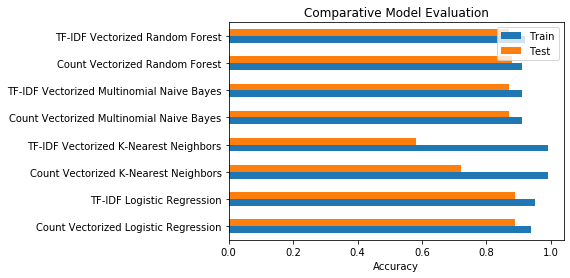

In [37]:
plt.figure(figsize= (10, 20))
accuracy_df[['Train', 'Test']].plot(kind = 'barh')
plt.xlabel('Accuracy')
plt.title('Comparative Model Evaluation')
plt.savefig('./imgs/Comparative Model Evaluation.png');

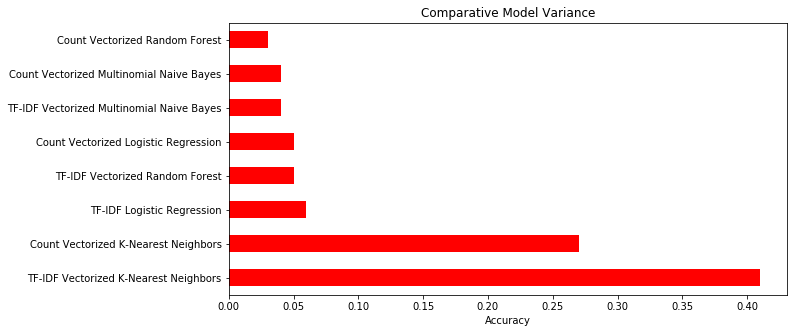

In [38]:
plt.figure(figsize= (10, 5))
accuracy_df['Variance'].sort_values(ascending = False).plot(kind= 'barh', color = 'red')
plt.xlabel('Accuracy')
plt.title('Comparative Model Variance')
plt.savefig('Comparative Model Variance');

### 5.2 Comparative ROC Curves

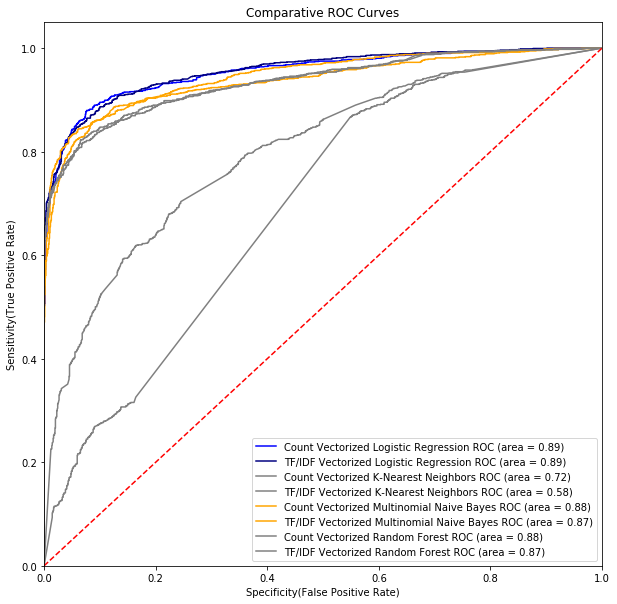

<Figure size 432x288 with 0 Axes>

In [39]:
plt.figure(figsize=(10, 10))

models = [
    { 
    'label':  'Count Vectorized Logistic Regression',
    'model': cvec_logreg_gs,
    'color' : 'blue'
    },
    {
    'label':  'TF/IDF Vectorized Logistic Regression',
    'model': tvec_logreg_gs,
    'color' : 'navy'
    },
    {
    'label':  'Count Vectorized K-Nearest Neighbors',
    'model': cvec_knn_gs,
    'color' : 'grey'
    },
    {
    'label':  'TF/IDF Vectorized K-Nearest Neighbors',
    'model': tvec_knn_gs,
    'color' : 'grey'
    },
    {
    'label':  'Count Vectorized Multinomial Naive Bayes',
    'model': cvec_mnnb_gs,
    'color' : 'orange'
    },
    {
    'label':  'TF/IDF Vectorized Multinomial Naive Bayes',
    'model': tvec_mnnb_gs,
    'color' : 'orange'
    },
    {    
    'label':  'Count Vectorized Random Forest',
    'model': cvec_rf_gs,
    'color' : 'grey'
    },
    {
    'label':  'TF/IDF Vectorized Random Forest',
    'model': tvec_rf_gs,
    'color' : 'grey'
    }
]

for m in models:
    model = m['model'] #select the model
    c = m['color']
    y_pred = model.predict(X_test) #predict the test data
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc), color = c)
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Comparative ROC Curves')
plt.legend(loc="lower right")
plt.show()# Display
plt.savefig('./imgs/compiled-roc.png')

As we saw from the scoring, the K-Nearest Neighbors models perform significantly worse than the others.  Once we've looked in greater detail, the Logistic Regression and Multinomial Naive Bayes are the best performing models with the largest aread under the ROC/AUC curve.

### 5.3 Top Model Confusion Matrix

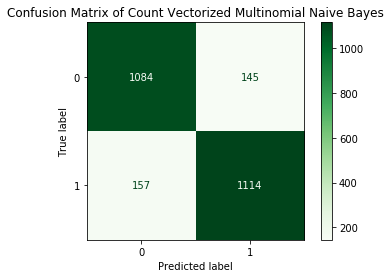

In [73]:
plot_confusion_matrix(cvec_mnnb_gs, X_test, y_test, cmap='Greens', values_format='d')
plt.title('Confusion Matrix of Count Vectorized Multinomial Naive Bayes')
plt.savefig('./imgs/model_cm.png');

### 5.4 Examining Misclassified Titles

Digging deeper into the data, we can take a look at our chosen model's shortcomings and see if we can figure out what was missed.

In [42]:
prediction = pd.DataFrame(data = cvec_mnnb_preds, columns=['prediction'], index = X_test.index.copy())
product = pd.concat([X_test, prediction, y_test], axis = 1)

In [43]:
misclassifieds = product[product['subreddit'] != product['prediction']]
misclassifieds['language'] = misclassifieds['title'].map(detect)
false_positives = product[(product['subreddit'] != product['prediction']) & (product['prediction'] == 1)]
false_negatives = product[(product['subreddit'] != product['prediction']) & (product['prediction'] == 0)]

In [44]:
misclassifieds.to_csv('./data/misclassified_titles.csv', index = False)

In [45]:
def get_top_n_bigrams(corpus, n=None): #using Susan Li's bigram function again
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [46]:
fp_common_bigrams = get_top_n_bigrams(false_positives['title'], 20)
fp_cb_df = pd.DataFrame(fp_common_bigrams, columns = ['Bigram', 'Count'])
fp_cb_df[:10]

,Bigram,Count
0,legal advice,3
1,wants to,3
2,what can,3
3,to be,3
4,can they,3
5,allowed to,3
6,by her,3
7,with him,3
8,of the,3
9,and had,3


In [47]:
fn_common_bigrams = get_top_n_bigrams(false_negatives['title'], 20)
fn_cb_df = pd.DataFrame(fn_common_bigrams, columns = ['Bigram', 'Count'])
fn_cb_df[:10]

,Bigram,Count
0,in the,9
1,in my,7
2,is this,6
3,it was,5
4,on the,5
5,this legal,5
6,what do,5
7,out of,5
8,on my,5
9,have to,4


Looking at my miscalssified titles, I'm noticing we're not seeing any of the most common bigrams we encountered in EDA.  One of the limitations of using bigrams in this set of data is the manner in which the r/bestoflegaladvice titles are set.  During EDA I noted the top bigrams in this subset included specific tags such as 'Actual post' and 'LAOP ___' (Legal Advice Original Post).  While this allows for more effective classification models when using bigrams, I'm seeing that the tags are not included in the misclassified titles.  In other words, when the model is trained on bigrams that include these common tags, it is a less effective classifier when those tags are missing.

One other point that came up when examining the misclassified titles was that we found a number of posts whose titles were not in english, when our model is primarily looking at an dataset that is in English

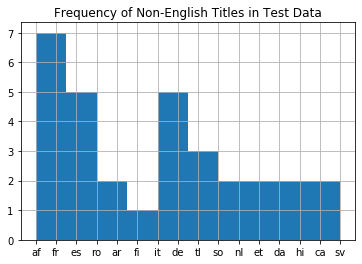

In [48]:
not_english = misclassifieds[misclassifieds['language'] != 'en']
not_english['language'].hist()
plt.title('Frequency of Non-English Titles in Test Data')
plt.savefig('./imgs/non-english-titles-hist.png');

In [49]:
not_english['title']

8723                        Dopehead/hooker neighbor lady
7717               Can your parents "control" your money?
9559                           Asshole parks in bike lane
163                                           Isro latest
6485                             Childcare Reimbursement?
6094                                 Parents against love
1261    إرهاب صهيونى.. جرافات الاحتلال تقطع جسد شاب فل...
9971                           Bad Joke Bad Consequences.
5595     Post study 485 visa vs student visa in Australia
1996                                            #swatting
7855                                  Aggressive neighbor
372     #SaidShiripour #Lebensgeschichte #Motivation #...
6073                                 Parents against love
8524           Is hooking up in a parking garage illegal?
8369                                      Large discounts
2933    Uahahahhaaaaaaahahahahhahahaahahahahhahahahahh...
4863              "It got left in my home. Can I keep it?
9677          

Although as a side note, of the 29 test data titles identified using the langdetect library's built in tools, some of the titles are actually in English, so I would be hesitent to use langdetect's detect function as a data cleaning tool without a deeper understanding of its tools.

## Phase 6 - Conclusions

### 6.0 Revist Problem Statement

Original problem statement: How well can we train a classification model to correctly classify the title of a subreddit post as belonging to the r/legaladvice subreddit or the r/bestoflegaladvice subreddit?  Which classification model type will be the strongest?

### 6.1 Conclusion

In [50]:
accuracy_df.sort_values(by = ['Variance'])

,Train,Test,Variance
Count Vectorized Random Forest,0.91,0.88,0.03
Count Vectorized Multinomial Naive Bayes,0.91,0.87,0.04
TF-IDF Vectorized Multinomial Naive Bayes,0.91,0.87,0.04
Count Vectorized Logistic Regression,0.94,0.89,0.05
TF-IDF Vectorized Random Forest,0.92,0.87,0.05
TF-IDF Logistic Regression,0.95,0.89,0.06
Count Vectorized K-Nearest Neighbors,0.99,0.72,0.27
TF-IDF Vectorized K-Nearest Neighbors,0.99,0.58,0.41


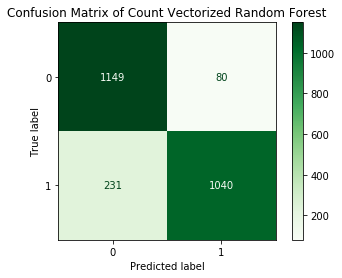

In [70]:
plot_confusion_matrix(cvec_rf_gs, X_test, y_test, cmap='Greens', values_format='d')
plt.title('Confusion Matrix of Count Vectorized Random Forest');

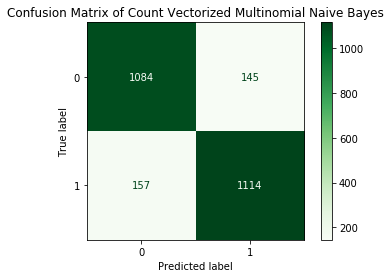

In [71]:
plot_confusion_matrix(cvec_mnnb_gs, X_test, y_test, cmap='Greens', values_format='d')
plt.title('Confusion Matrix of Count Vectorized Multinomial Naive Bayes');

Selecting Multinomial Naive Bayes over Random Forest due to a more balanced split of False Positives and False Negatives.

The best model we encountered was a Count Vectorizer paired with a Multinomial Naive Bayes model looking at bigrams.  As we predicted during EDA, we found that there was significant divergence between the most common bigrams of each subset, however as we looked at the misclassified data, we found that using these bigrams may be a crutch-  a large portion of the misclassified titles did not include common tags that are used by the redditors who rename the posts for r/bestoflegaladvice when tagging the post in the 'best of' subreddit.

This model is heartening as it was able to correctly classify 86% of the posts it had not seen before, significantly outperfoming our baseline of 50%.  It also revealed some significant room for improvement.

### 6.2 Recommendations for Further Research

The model as currently trained is a good proof of concept, and should research continue, can serve as a basis for additional insights.  

Future Iterations could include:

    1. gather data from the reddit text instead of the reddit title.  Changing the corpus used will allow the model to potentially predict which legal advice posts will become 'best of' and serve as a model that predicts popularity and engagement from content.
    2. strip out the crutch of title tags such as 'LAOP' to better tune the model.
    3. incorporate a sentiment analysis transformer in the pipeline
    4. train and incorporate a language filter to remove titles in a different language or potentially include this step as a transformer and add it as a feature to be examined.

### 6.3 Credits/ References

Randall Munroe- Reddit's New Comment Sorting System
https://redditblog.com/2009/10/15/reddits-new-comment-sorting-system/ 

various redditors in r/NoStupidQuestions:
https://www.reddit.com/r/NoStupidQuestions/comments/6cmz29/how_does_reddit_determine_the_best_ranking_in_a/

Caroline Schmitt- Sentiment Analysis lesson
https://git.generalassemb.ly/DSI-12-Echelon/nlp_modeling_and_sentiment_analysis


Susan Li- Exploratory Data Analysis primer for text data:
https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

Edward Ma - Named Entity Recognition roundup:
https://towardsdatascience.com/named-entity-recognition-3fad3f53c91e